In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd gdrive/My Drive/S-PLUS/BigData IAG/final project github/

/content/gdrive/My Drive/S-PLUS/BigData IAG/final project github


# Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits

from scipy.stats import gaussian_kde, pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# SDSS Selection

Go to [link] and download the files [files names].

Convert the fits files to CSV (using TOPCAT or astropy, for example).

Upload CSV files at 'sdss' folder.

## Load Data

In [4]:
# Load
gal_info = pd.read_csv('data/gal_specinfo_DR8.csv')
gal_extra = pd.read_csv('data/gal_specextra_DR8.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11,12,13,26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Cuts



*   SPECOBJID != NAN
*   RA, DEC != -9999
*   RELIABLE != 0
*   Z_WARNING == 0
*   BPT Class < 4
*   Stellar Mass > 0
*   log(sSFR) != -9999



In [5]:
# Exclude objects without SPECOBJID
gal_extra_index = gal_extra['SPECOBJID'].dropna()
gal_info_index  = gal_info['SPECOBJID'].dropna()

gal_extra = gal_extra.iloc[gal_extra_index.index]
gal_info  = gal_info.iloc[gal_info_index.index]

# Check
print(np.sum(gal_info['SPECOBJID'] == gal_extra['SPECOBJID']) / gal_extra.shape[0])

1.0


In [6]:
# Add corresponding columns
gal_extra['RA'] = gal_info['RA']
gal_extra['DEC'] = gal_info['DEC']
gal_extra['RELIABLE'] = gal_info['RELIABLE']
gal_extra['Z'] = gal_info['Z']
gal_extra['Z_WARNING'] = gal_info['Z_WARNING']
gal_extra['PLUG_MAG'] = gal_info['PLUG_MAG']

In [7]:
# Exclude nonsense objects: RA = -9999
print('Data set shape: ', gal_extra.shape)
print('# RA = -9999: ', np.sum(gal_extra['RA'] == -9999))
print('# DEC -9999: ', np.sum(gal_extra['DEC'] == -9999))

gal_extra = gal_extra[gal_extra['RA'] != -9999]
print('\nAfter cuts:')
print('Data set shape: ', gal_extra.shape)
print('# RA = -9999: ', np.sum(gal_extra['RA'] == -9999))
print('# DEC -9999: ', np.sum(gal_extra['DEC'] == -9999))

Data set shape:  (1472581, 51)
# RA = -9999:  7
# DEC -9999:  7

After cuts:
Data set shape:  (1472574, 51)
# RA = -9999:  0
# DEC -9999:  0


Text(0, 0.5, 'DEC')

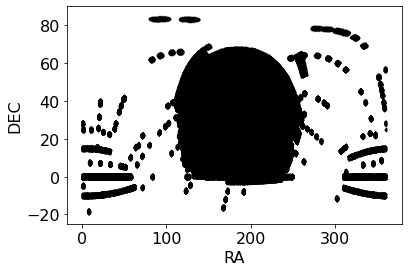

In [8]:
plt.scatter(gal_extra['RA'], gal_extra['DEC'],
            s=0.1, color='k', alpha=0.5)

plt.tick_params(labelsize=16)
plt.xlabel('RA', fontsize=16)
plt.ylabel('DEC', fontsize=16)

In [9]:
# Exclude nonsense objects: RELIABLE == 0
print('Data set shape: ', gal_extra.shape)
print('# Unreliable objects: ', np.sum(gal_extra['RELIABLE'] == 0))

# Fraction of unreliable objects
print('Fraction of unreliable objects: ',
      np.sum(gal_info['RELIABLE'] == 0)/gal_info.shape[0])

gal_extra = gal_extra[gal_extra['RELIABLE'] != 0]
print('\nAfter cuts:')
print('Data set shape: ', gal_extra.shape)
print('# Unreliable objects: ', np.sum(gal_extra['RELIABLE'] == 0))

Data set shape:  (1472574, 51)
# Unreliable objects:  546507
Fraction of unreliable objects:  0.37112593466844945

After cuts:
Data set shape:  (926067, 51)
# Unreliable objects:  0


In [10]:
# Exclude nonsense objects: Z_WARNING != 0
print('Data set shape: ', gal_extra.shape)
print('# objects with redshift warning: ', np.sum(gal_extra['Z_WARNING'] != 0))

gal_extra = gal_extra[gal_extra['Z_WARNING'] == 0]
print('\nAfter cuts:')
print('Data set shape: ', gal_extra.shape)
print('# objects with redshift warning: ', np.sum(gal_extra['Z_WARNING'] != 0))

Data set shape:  (926067, 51)
# objects with redshift warning:  6048

After cuts:
Data set shape:  (920019, 51)
# objects with redshift warning:  0


In [11]:
# Exclude nonsense objects: AGNs
print('Data set shape: ', gal_extra.shape)
print('# AGNs: ', np.sum(gal_extra['BPTCLASS'] > 3))

gal_extra = gal_extra[gal_extra['BPTCLASS'] < 4]
print('\nAfter cuts:')
print('Data set shape: ', gal_extra.shape)
print('# AGNs: ', np.sum(gal_extra['BPTCLASS'] > 3))

Data set shape:  (920019, 51)
# AGNs:  96443

After cuts:
Data set shape:  (823576, 51)
# AGNs:  0


In [13]:
# Exclude nonsense objects: negative Mstar
print('Data set shape: ', gal_extra.shape)
print('# log10(Mstar) = -9999: ', np.sum(gal_extra['LGM_TOT_P50'] == -9999))

gal_extra = gal_extra[gal_extra['LGM_TOT_P50'] > 0]
print('\nAfter cuts:')
print('Data set shape: ', gal_extra.shape)
print('# log10(Mstar) = -9999: ', np.sum(gal_extra['LGM_TOT_P50'] == -9999))

Data set shape:  (823576, 51)
# log10(Mstar) = -9999:  86562

After cuts:
Data set shape:  (737014, 51)
# log10(Mstar) = -9999:  0


In [14]:
# Exclude nonsense objects: flagged sSFR
print('Data set shape: ', gal_extra.shape)
print('# log(SFR) = -9999: ', np.sum(gal_extra['SFR_TOT_P50'] == -9999))

gal_extra = gal_extra[gal_extra['SFR_TOT_P2P5'] != -9999]
print('\nAfter cuts:')
print('Data set shape: ', gal_extra.shape)
print('# log(SFR) = -9999: ', np.sum(gal_extra['SFR_TOT_P50'] == -9999))

Data set shape:  (737014, 51)
# log(SFR) = -9999:  34979

After cuts:
Data set shape:  (702035, 51)
# log(SFR) = -9999:  0


In [15]:
# Get magnitudes: convert str to float
mags_str = gal_extra['PLUG_MAG']

mags = mags_str.str.extract('[-+]?(\d+\.\d+), (\d+\.\d+), (\d+\.\d+), (\d+\.\d+), (\d+\.\d+)').astype('float')
mags.columns = ['uSDSS', 'gSDSS', 'rSDSS', 'iSDSS', 'zSDSS']

print(mags.describe())

# Add magnitudes to the dataframe
gal_extra = pd.concat([gal_extra, mags], axis=1)

               uSDSS          gSDSS  ...          iSDSS          zSDSS
count  702035.000000  702035.000000  ...  702035.000000  702035.000000
mean       21.178271      19.548508  ...      18.217210      17.921345
std         0.911311       0.756005  ...       0.706042       0.744345
min        15.894900      15.349400  ...      14.052400      13.732000
25%        20.630200      19.120300  ...      17.826600      17.497700
50%        21.159800      19.566600  ...      18.221700      17.905900
75%        21.668800      19.983100  ...      18.642500      18.364400
max        30.874000      27.960000  ...      29.075300      28.193800

[8 rows x 5 columns]


### A look at the sample so far

In [16]:
# A look at the sample so far
def intermediate_hists(per):
  """
  - per: percentile
  """
  fig, ax = plt.subplots(1, 3, figsize=(12, 4))

  ax[0].hist(gal_extra['LGM_TOT_' + per], bins='scott', alpha=0.5)
  ax[0].set_xlabel('Stellar Mass', fontsize=16)

  ax[1].hist(gal_extra['SFR_TOT_' + per], bins='scott', alpha=0.5)
  ax[1].set_xlabel('log10(SFR)', fontsize=16)

  ax[2].hist(gal_extra['uSDSS'] - gal_extra['rSDSS'], bins='scott', alpha=0.5)
  ax[2].set_xlabel('$u - r$', fontsize=16)

  for i in range(3):
    ax[i].tick_params(labelsize=16)

  fig.tight_layout()
  plt.show()

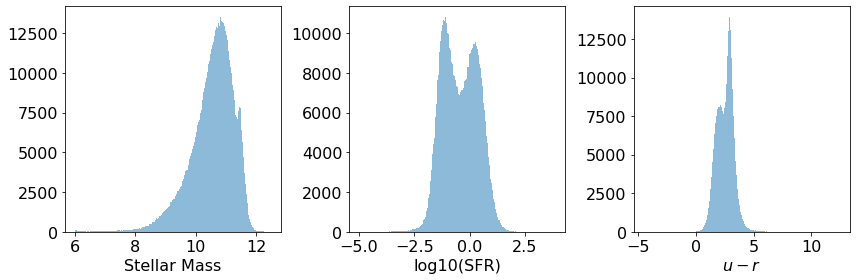

In [17]:
intermediate_hists('P50')

###After looking at the histograms, restrict the ranges of the properties

In [19]:
# Cuts in stellar mass
gal_extra = gal_extra[gal_extra['LGM_TOT_P50'] > 8]

# Cuts in color
gal_extra = gal_extra[gal_extra['uSDSS'] - gal_extra['rSDSS'] < 5]
gal_extra = gal_extra[gal_extra['uSDSS'] - gal_extra['rSDSS'] > 0]

## Plots of the final sample

### Color-Mass diagram:

In [20]:
def color_mass(gal_extra, num=None, countours_bool=False):

  """
  - gal_extra: pandas.DataFrame with the galaxies properties
  - num: number of objects to plot (doing countour plots with all of them
    might take a long time!)
  - countours_bool: boolean variable to plot or not the countours (might take
    long!)
  """

  if num != None:
    gal_extra = gal_extra.sample(n=num, random_state=42)

  fig, ax = plt.subplots(1, 2, figsize=(15, 6))

  if countours_bool:
    x = gal_extra['LGM_TOT_P50']
    y = gal_extra['uSDSS'] - gal_extra['rSDSS']
    xy = np.vstack((x, y))
    z = gaussian_kde(xy)(xy)
    z = z/np.max(z)
    
    ax[0].tricontour(x, y, z, levels=12, linewidths=1.25, colors='k')
    ax[1].tricontour(x, y, z, levels=12, linewidths=1.25, colors='k')


  plot0 = ax[0].scatter(gal_extra['LGM_TOT_P50'],
                        gal_extra['uSDSS'] - gal_extra['rSDSS'],
                        c=gal_extra['Z'],
                        s=1, alpha=1,
                        cmap='inferno')


  cb = plt.colorbar(plot0, ax=ax[0])
  cb.set_label(label='Redshift', size=16)
  cb.ax.tick_params(labelsize=14)


  plot1 = ax[1].scatter(gal_extra['LGM_TOT_P50'],
                        gal_extra['uSDSS'] - gal_extra['rSDSS'],
                        c=gal_extra['SFR_TOT_P50'],
                        s=1, alpha=1, vmin=-2.5, vmax=2.5,
                        cmap='jet_r')

  cb = plt.colorbar(plot1, ax=ax[1])
  cb.set_label(label='$\log_{10}$SFR [yr$^{-1}$]', size=16)
  cb.ax.tick_params(labelsize=14)


  for i in range(2):
    ax[i].tick_params(labelsize=16)
    ax[i].set_xlabel('$\log_{10}\ M_{star}$ $[M_\odot]$', fontsize=16)
    ax[i].set_ylabel('$u - r$', fontsize=16)

  plt.tight_layout()

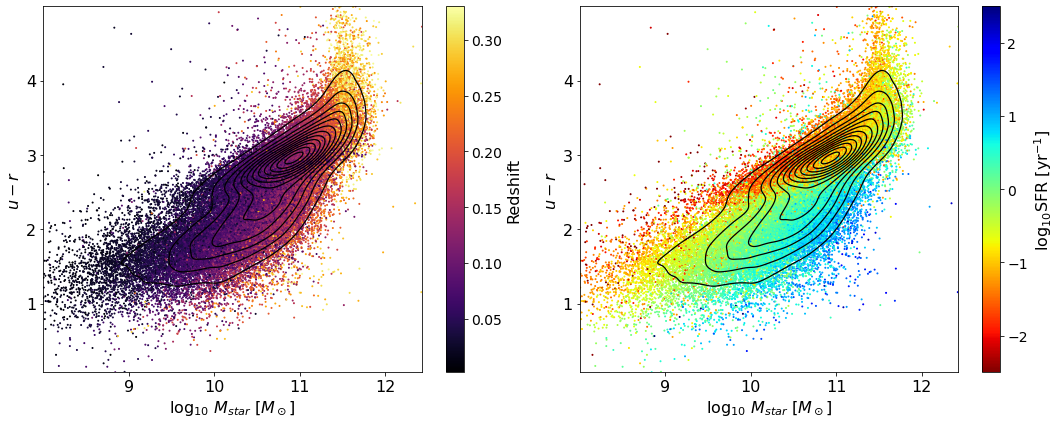

In [21]:
color_mass(gal_extra, 50000, True)

### Histograms:

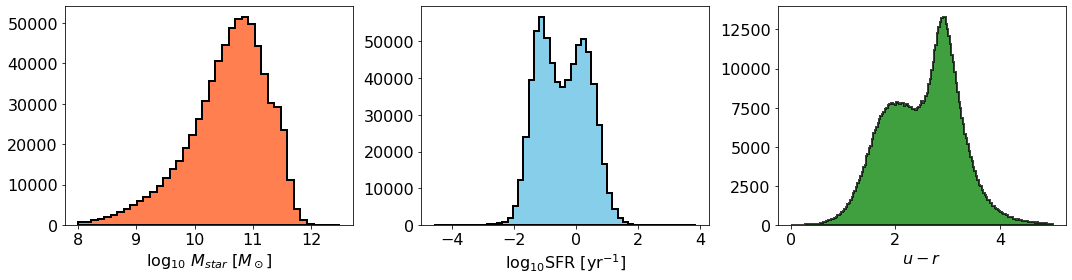

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].hist(gal_extra['LGM_TOT_P50'],
           bins=40, alpha=1, linewidth=2, color='coral', edgecolor='k', histtype='stepfilled')
ax[0].set_xlabel('$\log_{10}\ M_{star}$ $[M_\odot]$', fontsize=16)


ax[1].hist(gal_extra['SFR_TOT_P50'],
           bins=50, alpha=1, color='skyblue', edgecolor='k', histtype='stepfilled', linewidth=2)
ax[1].set_xlabel('$\log_{10}$SFR [yr$^{-1}$]', fontsize=16)


ax[2].hist(gal_extra['uSDSS'] - gal_extra['rSDSS'],
           bins='scott', alpha=0.75, color='green', edgecolor='k', histtype='stepfilled', linewidth=2)
ax[2].set_xlabel('$u - r$', fontsize=16)


for i in range(3):
  ax[i].tick_params(labelsize=16)

plt.tight_layout()
plt.show()

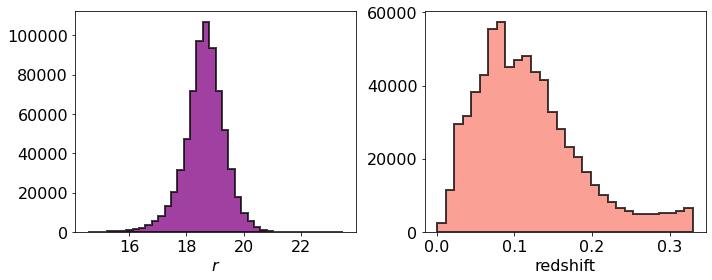

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(gal_extra['rSDSS'],
           bins=40, alpha=0.75, color='purple', edgecolor='k', histtype='stepfilled', linewidth=2)
ax[0].set_xlabel('$r$', fontsize=16)

ax[1].hist(gal_extra['Z'],
           bins=30, alpha=0.75, color='salmon', edgecolor='k', histtype='stepfilled', linewidth=2)
ax[1].set_xlabel('redshift', fontsize=16)


for i in range(2):
  ax[i].tick_params(labelsize=16)

plt.tight_layout()
plt.show()

In [26]:
gal_extra.shape

(695234, 56)

### Save:    sdss_dr8.csv

In [ ]:
gal_extra.to_csv('data/sdss_dr8.csv', index=False)

# S-PLUS Query


The query is done in two stages:

1.   cone search within 1 arcsec;
2.   query with IDs to get the VACs.




In [ ]:
!pip install splusdata

In [ ]:
import getpass
import splusdata

print("Getting connection with S-PLUS")
username = input(prompt="Login: ")
password = getpass.getpass("Password: ")
conn = splusdata.connect(username, password)

Getting connection with S-PLUS
Login: nrodrigues
Password: ··········
You have access to internal data


In [ ]:
# Load SDSS catalog obtained in the previous section
sdss_data = pd.read_csv('data/sdss_dr8.csv')

In [ ]:
# Get RA and DEC to do the search (only the first 5k)
sdss_radec = sdss_data.loc[:5000, ['RA', 'DEC']]

### Start searching for the IDs of the objects within 1 arcsec

In [ ]:
ID_Query = (f"""SELECT det.id, det.RA, det.DEC
            FROM TAP_UPLOAD.upload AS tap
            JOIN "idr3"."reference" AS det
            ON 1 = CONTAINS( POINT('', det.ra, det.dec),
            CIRCLE('', tap.ra, tap.dec, 1. / 3600))""")

In [ ]:
dr3_ids = conn.query(query=ID_Query, table_upload=sdss_radec)

Cutting to the first 6000 objects!
finished


### Now we get other values based on the IDs:

In [ ]:
# To crossmatch using the IDs: peguei do S-PLUS cloud
My_Query = (f"""SELECT ref."ID", ref."RA", ref."DEC", r."PhotoFlag_r",
            u."u_auto", g."g_auto", r."r_auto", i."i_auto", z."z_auto",
            u."e_u_auto", g."e_g_auto", r."e_r_auto", i."e_i_auto", z."e_z_auto",
            j0378."J0378_auto",j0395."J0395_auto",j0410."J0410_auto",j0430."J0430_auto",j0515."J0515_auto",j0660."J0660_auto",j0861."J0861_auto",
            j0378."e_J0378_auto",j0395."e_J0395_auto",j0410."e_J0410_auto",j0430."e_J0430_auto",j0515."e_J0515_auto",j0660."e_J0660_auto",j0861."e_J0861_auto",
            pz.zml, pz.zml_err, pz.odds, sgq.PROB_GAL, sgq.PROB_STAR

            FROM TAP_UPLOAD.upload AS tap
            JOIN "idr3"."reference" AS ref ON (tap.ID = ref.ID)
            JOIN "idr3"."u_band" AS u ON (tap.ID = u.ID)
            JOIN "idr3"."g_band" AS g ON (tap.ID = g.ID)
            JOIN "idr3"."r_band" AS r ON (tap.ID = r.ID)
            JOIN "idr3"."i_band" AS i ON (tap.ID = i.ID)
            JOIN "idr3"."z_band" AS z ON (tap.ID = z.ID)
            JOIN "idr3"."j0378_band" AS j0378 ON (tap.ID = j0378.ID)
            JOIN "idr3"."j0395_band" AS j0395 ON (tap.ID = j0395.ID)
            JOIN "idr3"."j0410_band" AS j0410 ON (tap.ID = j0410.ID)
            JOIN "idr3"."j0430_band" AS j0430 ON (tap.ID = j0430.ID)
            JOIN "idr3"."j0515_band" AS j0515 ON (tap.ID = j0515.ID)
            JOIN "idr3"."j0660_band" AS j0660 ON (tap.ID = j0660.ID)
            JOIN "idr3"."j0861_band" AS j0861 ON (tap.ID = j0861.ID)
            JOIN idr3_vacs.photoz AS pz ON (tap.ID = pz.ID)
            JOIN idr3_vacs.star_galaxy_quasar AS sgq ON (tap.ID = sgq.ID)
            """)

In [ ]:
dr3_vacs = conn.query(query=My_Query, table_upload=dr3_ids)

finished


In [ ]:
df = pd.DataFrame(np.array(dr3_vacs))

In [ ]:
print(df.head())
print(df.describe())

                            ID          RA  ...  PROB_GAL  PROB_STAR
0  b'iDR3.SPLUS-n01s01.005704'  150.231400  ...      0.99       0.01
1  b'iDR3.SPLUS-n01s01.011021'  150.097784  ...      0.95       0.05
2  b'iDR3.SPLUS-n01s01.004855'  150.190774  ...      1.00       0.00
3  b'iDR3.SPLUS-n01s01.007417'  150.268467  ...      0.99       0.01
4  b'iDR3.SPLUS-n01s01.003971'  150.346302  ...      1.00       0.00

[5 rows x 33 columns]
               RA         DEC  PhotoFlag_r  ...        odds    PROB_GAL   PROB_STAR
count  324.000000  324.000000   324.000000  ...  324.000000  324.000000  324.000000
mean   150.732617    0.323753     1.512346  ...    0.878723    0.993302    0.005062
std      0.412920    0.521663     1.071659  ...    0.120002    0.046178    0.035995
min    150.077910   -0.696309     0.000000  ...    0.410619    0.210000    0.000000
25%    150.346470   -0.081508     0.000000  ...    0.815153    1.000000    0.000000
50%    150.750596    0.330155     2.000000  ...    0.921403

## Loop

The system only allows 6000 objects in the query. Therefore, I split the data into smaller slices of size 5000 and repeat the query until it runs over all the sample.

In [ ]:
# Limit number of objects
nlim = 5000

In [ ]:
for slice_ in range(1, int(sdss_radec.shape[0]/nlim)):
  
  print('slice: ', slice_)

  # data slice to do the cross-match
  sdss_slice = sdss_data[slice_ * nlim:(slice_ + 1) * nlim]
  sdss_slice_radec = sdss_slice[['RA', 'DEC']]

  # get IDs with the cone search
  dr3_ids = conn.query(query=ID_Query, table_upload=sdss_slice_radec)
  print('# objects found: ', len(dr3_ids))

  # get VACs with the IDs
  dr3_vacs = conn.query(query=My_Query, table_upload=dr3_ids)
  print('VAC length: ', len(dr3_vacs))

  df = pd.concat([df, pd.DataFrame(np.array(dr3_vacs))])

In [ ]:
df.describe()

,RA,DEC,PhotoFlag_r,u_auto,g_auto,r_auto,i_auto,z_auto,e_u_auto,e_g_auto,e_r_auto,e_i_auto,e_z_auto,J0378_auto,J0395_auto,J0410_auto,J0430_auto,J0515_auto,J0660_auto,J0861_auto,e_J0378_auto,e_J0395_auto,e_J0410_auto,e_J0430_auto,e_J0515_auto,e_J0660_auto,e_J0861_auto,zml,zml_err,odds,PROB_GAL,PROB_STAR
count,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000,33015.000000
mean,130.301640,-0.225714,1.435893,23.141680,18.176764,17.332546,16.915398,16.687468,1.518418,0.063387,0.031051,0.026189,0.040000,21.893198,22.912045,21.275654,19.968981,18.074549,17.372103,16.913412,1.543749,1.571168,1.193329,0.705715,1.155270,0.197261,0.235165,0.119374,0.015420,0.833020,0.988716,0.007578
std,122.063535,0.965551,1.150067,16.304846,2.650266,1.942243,1.534972,1.796066,20.783398,0.684509,0.474208,0.340786,0.401929,14.243597,17.181753,13.598480,10.338416,4.925152,3.768152,4.074366,53.439568,6.701779,25.920677,6.908898,162.623505,8.433542,8.491743,0.067195,0.012223,0.158923,0.056424,0.040173
min,0.006467,-3.427579,0.000000,10.545296,9.990945,9.548342,9.378713,9.307027,0.003396,0.000843,0.000686,0.000846,0.001249,10.091816,9.681654,10.061409,10.161985,9.675006,9.549048,9.212207,0.003396,0.003694,0.003619,0.003187,0.001862,0.000820,0.001762,0.005500,0.003232,0.079247,0.010000,0.000000
25%,30.768076,-0.826421,0.000000,19.033620,17.628746,16.895164,16.503686,16.249208,0.101843,0.021487,0.012878,0.012971,0.019075,18.699394,18.451059,18.321115,18.024426,17.312567,16.793175,16.300477,0.122035,0.160031,0.122650,0.089766,0.040495,0.013631,0.025314,0.069500,0.009355,0.741128,1.000000,0.000000
50%,52.371271,-0.158083,2.000000,19.696413,18.179960,17.411060,17.005713,16.746094,0.167233,0.031377,0.018135,0.018298,0.027273,19.317839,19.113787,18.976650,18.688265,17.855730,17.300400,16.805357,0.190764,0.256928,0.196935,0.147537,0.058466,0.019041,0.035787,0.105500,0.012787,0.887042,1.000000,0.000000
75%,186.806606,0.532552,2.000000,20.395473,18.608183,17.730174,17.325293,17.095671,0.301063,0.046634,0.025188,0.025442,0.039046,19.968803,19.804819,19.615515,19.324940,18.262644,17.624910,17.147584,0.323478,0.453250,0.331479,0.245456,0.086473,0.026552,0.051033,0.151500,0.018454,0.961793,1.000000,0.000000
max,359.988815,1.273309,19.000000,99.000000,99.000000,99.000000,99.000000,99.000000,3479.226562,22.956800,22.819035,22.447174,21.277975,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,8659.744141,515.849365,4615.327148,1009.723877,29529.554688,853.300842,970.252563,0.834500,0.723020,0.999666,1.000000,0.950000


In [ ]:
# Remove duplicates
df = df.drop_duplicates(['RA', 'DEC'])

## Save: splus_query.csv

In [ ]:
df.to_csv('data/splus_query.csv', index=False)

# Merged table: merged.csv

Go to topcat, do the cross-match between sdss_dr8.csv and splus_query.csv once again, get the match table with both SDSS and S-PLUS information. Name this file as merged.csv and upload to the data folder.


Load file, remove ID duplicates and save it again.

In [65]:
merged = pd.read_csv('data/merged.csv')

# Drop duplicates (there are only a few)
merged = merged.drop_duplicates('ID')

merged.to_csv('data/merged.csv', index=False)

# Final Sample

The final sample is the merged.csv file.

Let's take a look at this sample.

In [ ]:
df = pd.read_csv('data/merged.csv')

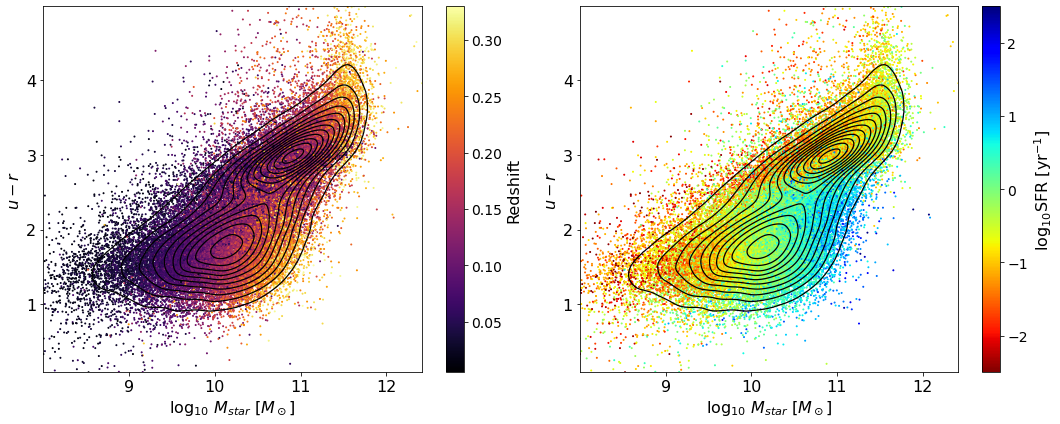

In [227]:
# SDSS properties in the sample
color_mass(df, num=None, countours_bool=True)

In [ ]:
xy = np.vstack([x, y])
  z = gaussian_kde(xy)(xy)
  im00 = axs[0, 1].scatter(x, y, c = z/max(z), s=100, edgecolor='', cmap = 'rainbow', marker = '.')

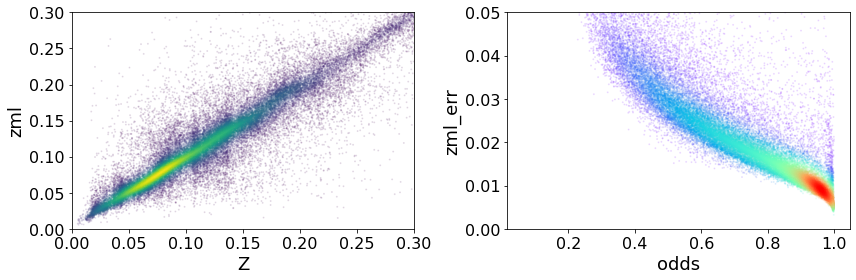

In [230]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

x = df['Z']
y = df['zml']
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

ax[0].scatter(df['Z'], df['zml'], c=z, s=1, alpha=0.1, cmap='viridis')

ax[0].set_xlabel('Z', fontsize=18)
ax[0].set_ylabel('zml', fontsize=18)
ax[0].tick_params(labelsize=16)

ax[0].set_xlim(0, 0.3)
ax[0].set_ylim(0, 0.3)

x = df['odds']
y = df['zml_err']
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

ax[1].scatter(df['odds'], df['zml_err'], c=z, s=1, alpha=0.1, cmap='rainbow')

ax[1].set_xlabel('odds', fontsize=18)
ax[1].set_ylabel('zml_err', fontsize=18)
ax[1].tick_params(labelsize=16)

ax[1].set_ylim(0, 0.05)

plt.tight_layout()

plt.show()

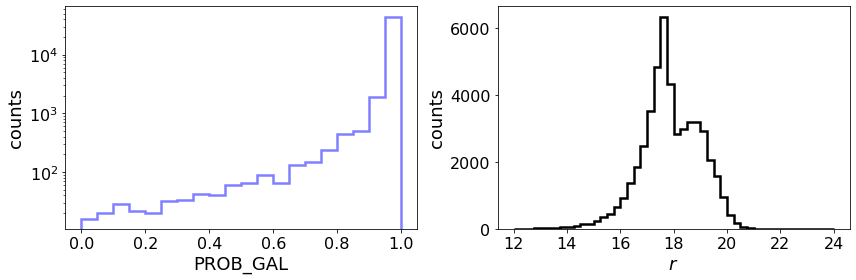

In [183]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].hist(df['PROB_GAL'], bins=20, histtype='step', linewidth=2.5, color='b', alpha=0.5)

ax[0].set_xlabel('PROB_GAL', fontsize=18)
ax[0].set_ylabel('counts', fontsize=18)
ax[0].tick_params(labelsize=16)

ax[0].set_yscale('log')

ax[1].hist(df['r_auto'], bins=48, histtype='step', linewidth=2.5, color='k', range=(12, 24), label='S-PLUS')

ax[1].set_xlabel('$r$', fontsize=18)
ax[1].set_ylabel('counts', fontsize=18)
ax[1].tick_params(labelsize=16)


plt.tight_layout()

plt.show()

# CIGALE Pre-processing

With our S-PLUS-SDSS cross-match sample in hand, we can now run CIGALE to predict the physical properties using S-PLUS photometry and compare the results with MPA-JHU prediction.


Here I do the following procedures:



*   Sort the filters according to $\lambda$ or to CIGALE input file
*   Convert magnitudes → $f_\lambda$ → $f$ [mJy]. To run CIGALE I only need fluxes in [mJy], but I added the intermediate $f_\lambda$ for didatic purposes.



In [29]:
merged = pd.read_csv('data/merged.csv')

## Sort Filters

In [27]:
def sort_wavelengths(df):
  """
  Sort the filters in the correct wavelength order.
  - df: pandas.DataFrame
  """

  df = df[['u_auto', 'J0378_auto', 'J0395_auto', 'J0410_auto', 'J0430_auto',
           'g_auto', 'J0515_auto', 'r_auto', 'J0660_auto', 'i_auto',
           'J0861_auto', 'z_auto',
           'e_u_auto', 'e_J0378_auto', 'e_J0395_auto', 'e_J0410_auto', 'e_J0430_auto',
           'e_g_auto', 'e_J0515_auto', 'e_r_auto', 'e_J0660_auto', 'e_i_auto',
           'e_J0861_auto', 'e_z_auto']]

  return df

In [28]:
def sort_cigale(df, col_id='ID', col_z='zml', select=True):
  """
  Sort the columns in CIGALE input style (ID, z, (flux, err)).
  - df: pandas.DataFrame
  - col_id: ID column name
  - col_z: redshift column name
  - select: True if you need to select the columns from df.
            False if you need only to sort/name them properly.
  """

  if select:
    df = df[[col_id,
             col_z,
            'u_auto','e_u_auto',
            'J0378_auto','e_J0378_auto',
            'J0395_auto','e_J0395_auto',
            'J0410_auto','e_J0410_auto',
            'J0430_auto','e_J0430_auto',
            'g_auto','e_g_auto',
            'J0515_auto','e_J0515_auto',
            'r_auto','e_r_auto',
            'J0660_auto','e_J0660_auto',
            'i_auto','e_i_auto',
            'J0861_auto','e_J0861_auto',
            'z_auto','e_z_auto']]


  df.columns = ['id',
                'redshift',
                'u','u_err',
                'J0378','J0378_err',
                'J0395','J0395_err',
                'J0410','J0410_err',
                'J0430','J0430_err',
                'g','g_err',
                'J0515','J0515_err',
                'r','r_err',
                'J0660','J0660_err',
                'i','i_err',
                'J0861','J0861_err',
                'z','z_err']

  return df

In [30]:
data = sort_cigale(merged)

## Convert Magnitude → Flux

$$\text{mag}_\text{AB} = -2.5*\log_{10}(f_\nu)-48.6$$

$$f_\lambda = \frac{c}{\lambda^2}*f_\nu$$

In [32]:
vel_light = 2.99792458 * 10**18  # angstrom/s


def flux(m, wavelength):  # flux in units of erg/s.cm2.AA
  """
  m: magnitude
  """
  return (vel_light / wavelength**2) * 10**(-0.4 * (m + 48.6))


def dflux(m, wavelength, sm):
  """
  m: magnitude
  sm: sigma magnitude
  """
  return (np.log(10) * flux(m, wavelength) * 0.4 * sm)

In [33]:
# Effective wavelength of each filter
central_lambda = np.array([3533.35, 3773.12, 3940.71, 4094.93, 4292.15, 4758.49,
                           5133.15, 6251.89, 6613.86, 7670.63, 8607.25, 8941.44])

In [34]:
print(data.head())

                            id  redshift  ...          z     z_err
0  b'iDR3.SPLUS-n01s01.005704'     0.276  ...  17.363243  0.071900
1  b'iDR3.SPLUS-n01s01.011021'     0.086  ...  15.266716  0.014202
2  b'iDR3.SPLUS-n01s01.004855'     0.178  ...  16.058468  0.026815
3  b'iDR3.SPLUS-n01s01.007417'     0.097  ...  15.918140  0.020525
4  b'iDR3.SPLUS-n01s01.003971'     0.086  ...  15.736536  0.017663

[5 rows x 26 columns]


In [35]:
remain_info = data.iloc[:, :2]

mag = data.iloc[:, 2::2]
err = data.iloc[:, 3::2]

mag_cols = mag.columns
err_cols = err.columns

aux_cols = ['{}'.format(_) for _ in range(12)]

In [36]:
mag.columns = aux_cols
err.columns = aux_cols

mag[mag == 99] = err[mag == 99]  # Set to mag lim
mag[mag ==-99] = err[mag ==-99]  # Set to zero

In [37]:
mag_flux = flux(mag, central_lambda)
mag_flux[mag == 0] = -9999

err_flux = dflux(mag, central_lambda, err)

In [38]:
# Build flux dataset
mag_flux.columns = mag_cols
err_flux.columns = err_cols

flam = pd.concat([remain_info, mag_flux, err_flux], 1)

In [39]:
flam.head()

,id,redshift,u,J0378,J0395,J0410,J0430,g,J0515,r,J0660,i,J0861,z,u_err,J0378_err,J0395_err,J0410_err,J0430_err,g_err,J0515_err,r_err,J0660_err,i_err,J0861_err,z_err
0,b'iDR3.SPLUS-n01s01.005704',0.276,2.733749e-17,1.819747e-17,2.954240e-17,4.353311e-17,8.780663e-17,6.990341e-17,7.092197e-17,1.426033e-16,1.194088e-16,1.715076e-16,1.592581e-16,1.544218e-16,1.944967e-17,3.613314e-16,4.269801e-17,4.095969e-17,3.837091e-17,1.466151e-17,2.475547e-17,8.559190e-18,9.086158e-18,7.749398e-18,1.311956e-17,1.022617e-17
1,b'iDR3.SPLUS-n01s01.011021',0.086,1.419656e-17,9.781590e-17,4.675454e-17,3.261196e-16,5.544139e-16,7.985726e-16,1.096684e-15,1.120761e-15,1.193639e-15,1.103513e-15,1.096022e-15,1.064926e-15,2.872776e-16,3.454766e-17,5.592403e-17,5.606649e-17,5.266951e-17,2.028046e-17,3.452941e-17,1.206620e-17,1.288502e-17,1.077039e-17,1.795293e-17,1.392958e-17
2,b'iDR3.SPLUS-n01s01.004855',0.178,1.388328e-17,2.034218e-16,1.079473e-16,1.942512e-16,3.097754e-16,3.005816e-16,3.861258e-16,5.203578e-16,5.166846e-16,5.246202e-16,5.111428e-16,5.135924e-16,2.394980e-17,3.271496e-17,5.276491e-17,5.068052e-17,4.752733e-17,1.818135e-17,3.078923e-17,1.068497e-17,1.136826e-17,9.645650e-18,1.629791e-17,1.268450e-17
3,b'iDR3.SPLUS-n01s01.007417',0.097,1.478443e-16,2.067961e-16,1.373922e-16,2.417841e-16,1.927604e-16,4.110002e-16,6.096593e-16,5.627937e-16,5.923701e-16,5.976496e-16,5.880544e-16,5.844532e-16,2.093540e-17,2.843916e-17,4.582276e-17,4.404905e-17,4.111274e-17,1.586080e-17,2.701555e-17,9.340083e-18,9.961459e-18,8.434579e-18,1.422204e-17,1.104854e-17
4,b'iDR3.SPLUS-n01s01.003971',0.086,3.239731e-16,3.888161e-16,4.074536e-16,5.597836e-16,6.293226e-16,7.472852e-16,8.152853e-16,8.118550e-16,7.981445e-16,7.814202e-16,6.943267e-16,6.908621e-16,2.142902e-17,2.911771e-17,4.694015e-17,4.511141e-17,4.224833e-17,1.626406e-17,2.757480e-17,9.562473e-18,1.018231e-17,8.599892e-18,1.447763e-17,1.123929e-17


## Convert $f_\lambda$ → mJy

$$ \text{mJy} = 10^{26} f_\nu = 10^{26} f_\lambda \frac{\lambda^2}{c} $$

In [40]:
vel_light = 2.99792458 * 10**18  # angstrom/s
central_lambda = np.array([3533.35, 3773.12, 3940.71, 4094.93, 4292.15, 4758.49,
                           5133.15, 6251.89, 6613.86, 7670.63, 8607.25, 8941.44])

central_lambda = np.tile(central_lambda.reshape(12, 1), 2).reshape(24)

In [41]:
# Get fluxes and errors
data_flam = flam.iloc[:, 2:]

# Convert to [mJy]
data_mJy = data_flam * (central_lambda)**2 / (vel_light) * 1e26

In [42]:
print(data_mJy.head())
print(data_mJy.describe())

          u     J0378     J0395  ...     i_err  J0861_err     z_err
0  0.011384  0.007578  0.014029  ...  0.019150   0.034988  0.027271
1  0.005912  0.040734  0.022203  ...  0.026616   0.047877  0.037148
2  0.005782  0.084713  0.051262  ...  0.023836   0.043464  0.033827
3  0.061568  0.086118  0.065244  ...  0.020844   0.037928  0.029465
4  0.134915  0.161919  0.193490  ...  0.021252   0.038609  0.029973

[5 rows x 24 columns]
                  u         J0378  ...     J0861_err         z_err
count  4.837800e+04  4.837800e+04  ...  48378.000000  48378.000000
mean   7.414160e-02  9.108242e-02  ...      0.026822      0.019689
std    1.112888e+00  1.556042e+00  ...      0.028723      0.020744
min    2.343022e-07  6.038057e-08  ...      0.001687      0.001223
25%    1.708572e-02  2.107504e-02  ...      0.016264      0.012202
50%    3.362378e-02  4.082771e-02  ...      0.022155      0.016635
75%    6.418021e-02  7.718693e-02  ...      0.029896      0.022326
max    2.197261e+02  2.925807e+02

In [43]:
# Add ID and redshift to the converted data
data_mJy = pd.concat([flam[['id', 'redshift']], data_mJy], axis=1)

In [44]:
data_mJy.head()

,id,redshift,u,J0378,J0395,J0410,J0430,g,J0515,r,J0660,i,J0861,z,u_err,J0378_err,J0395_err,J0410_err,J0430_err,g_err,J0515_err,r_err,J0660_err,i_err,J0861_err,z_err
0,b'iDR3.SPLUS-n01s01.005704',0.276,0.011384,0.007578,0.014029,0.020673,0.045484,0.036210,0.039669,0.079763,0.073378,0.105393,0.120287,0.116634,0.017095,0.317580,0.055669,0.053402,0.055988,0.021393,0.048586,0.016799,0.022454,0.019150,0.034988,0.027271
1,b'iDR3.SPLUS-n01s01.011021',0.086,0.005912,0.040734,0.022203,0.154866,0.287185,0.413659,0.613414,0.626881,0.733503,0.678120,0.827822,0.804335,0.252493,0.030364,0.072912,0.073098,0.076851,0.029592,0.067769,0.023682,0.031841,0.026616,0.047877,0.037148
2,b'iDR3.SPLUS-n01s01.004855',0.178,0.005782,0.084713,0.051262,0.092245,0.160463,0.155701,0.215974,0.291054,0.317508,0.322384,0.386065,0.387915,0.021050,0.028754,0.068793,0.066076,0.069348,0.026529,0.060428,0.020971,0.028093,0.023836,0.043464,0.033827
3,b'iDR3.SPLUS-n01s01.007417',0.097,0.061568,0.086118,0.065244,0.114818,0.099850,0.212897,0.341004,0.314790,0.364017,0.367262,0.444156,0.441436,0.018400,0.024996,0.059742,0.057430,0.059988,0.023143,0.053022,0.018331,0.024617,0.020844,0.037928,0.029465
4,b'iDR3.SPLUS-n01s01.003971',0.086,0.134915,0.161919,0.193490,0.265828,0.325988,0.387092,0.456018,0.454099,0.490468,0.480191,0.524423,0.521806,0.018834,0.025592,0.061199,0.058815,0.061645,0.023731,0.054119,0.018768,0.025163,0.021252,0.038609,0.029973


## Save: splus_input.csv

In [55]:
data_mJy.to_csv('data/splus_input.csv', index=False)

# CIGALE results analysis

Get results.fits in CIGALE output file, convert into CSV with topcat

In [191]:
# Load results table
preds = pd.read_csv('cigale/results.csv')

In [190]:
# Join the predictions with the other informations
merged = pd.read_csv('splus/merged.csv')

df = pd.concat([merged, preds], axis=1)

In [188]:
print(df.head())
print(df.describe())

      SPECOBJID  PLATEID    MJD  ...    best.i  best.F0861    best.z
0  3.017442e+17      268  51633  ...  0.097573    0.109256  0.113677
1  3.017445e+17      268  51633  ...  0.674738    0.734236  0.769121
2  3.017448e+17      268  51633  ...  0.323548    0.350536  0.366215
3  3.017451e+17      268  51633  ...  0.374259    0.405902  0.426356
4  3.017453e+17      268  51633  ...  0.534587    0.581726  0.609365

[5 rows x 208 columns]
          SPECOBJID       PLATEID  ...    best.F0861        best.z
count  4.836300e+04  48363.000000  ...  48363.000000  48363.000000
mean   8.212827e+17    729.367843  ...      0.258624      0.269804
std    4.675142e+17    415.235942  ...      1.457547      1.519288
min    3.017442e+17    268.000000  ...      0.002831      0.002985
25%    4.358232e+17    387.000000  ...      0.066654      0.069026
50%    5.832547e+17    518.000000  ...      0.156547      0.162299
75%    1.159699e+18   1030.000000  ...      0.255594      0.265666
max    2.971419e+18   2639

## CIGALE vs. MPA-JHU

In [212]:
def compute_scores(df):

  print('Mstar PCC: ',
        pearsonr(np.log10(df['bayes.stellar.m_star']), df['LGM_TOT_P50'])[0])

  print('Mstar MSE: ',
        mean_squared_error(np.log10(df['bayes.stellar.m_star']), df['LGM_TOT_P50']))
  
  print('SFR PCC: ',
        pearsonr(np.log10(df['bayes.sfh.sfr']), df['SFR_TOT_P50'])[0])

  print('SFR MSE: ',
        mean_squared_error(np.log10(df['bayes.sfh.sfr']), df['SFR_TOT_P50']))

## Color-mass diagrams

In [208]:
def color_mass_splus(df, countours_bool=False):

  """
  - df: pandas.DataFrame with the galaxies properties
  - num: number of objects to plot (doing countour plots with all of them
    might take a long time!)
  - countours_bool: boolean variable to plot or not the countours (might take
    long!)
  """

  df = df[(df['u_auto'] - df['r_auto'] < 5) & (df['u_auto'] - df['r_auto'] > 0)]

  fig, ax = plt.subplots(1, 2, figsize=(15, 6))

  if countours_bool:
    x = np.log10(df['bayes.stellar.m_star'])
    y = df['u_auto'] - df['r_auto']
    xy = np.vstack((x, y))
    z = gaussian_kde(xy)(xy)
    z = z/np.max(z)
    
    ax[0].tricontour(x, y, z, levels=12, linewidths=1.25, colors='k')
    ax[1].tricontour(x, y, z, levels=12, linewidths=1.25, colors='k')


  plot0 = ax[0].scatter(np.log10(df['bayes.stellar.m_star']),
                        df['u_auto'] - df['r_auto'],
                        c=df['zml'],
                        s=1, alpha=1,
                        cmap='inferno')


  cb = plt.colorbar(plot0, ax=ax[0])
  cb.set_label(label='Redshift', size=16)
  cb.ax.tick_params(labelsize=14)


  plot1 = ax[1].scatter(np.log10(df['bayes.stellar.m_star']),
                        df['u_auto'] - df['r_auto'],
                        c=np.log10(df['bayes.sfh.sfr']),
                        s=1, alpha=1, vmin=-2.5, vmax=2.5,
                        cmap='jet_r')

  cb = plt.colorbar(plot1, ax=ax[1])
  cb.set_label(label='$\log_{10}$SFR [yr$^{-1}$]', size=16)
  cb.ax.tick_params(labelsize=14)


  for i in range(2):
    ax[i].tick_params(labelsize=16)
    ax[i].set_xlabel('$\log_{10}\ M_{star}$ $[M_\odot]$', fontsize=16)
    ax[i].set_ylabel('$u - r$', fontsize=16)

  plt.tight_layout()

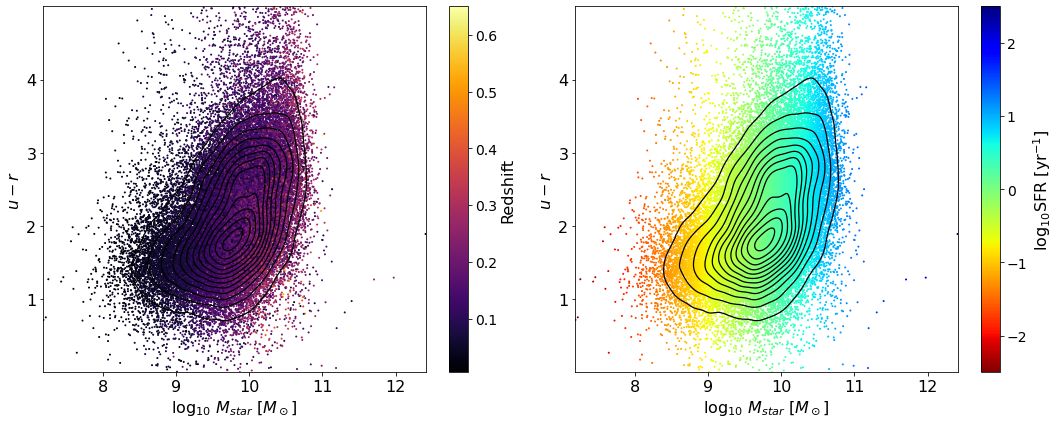

In [93]:
# No cuts
color_mass_splus(df, True)

In [209]:
compute_scores(df)

Mstar PCC:  0.885736789279995
Mstar MSE:  0.4634609020339241
SFH PCC:  0.1936874956105828
SFH MSE:  0.8645982768603397


Cuts in ODDS and in the $r$ band:

In [220]:
df_cuts = df[(df['odds'] > 0.9) & (df['r_auto'] < 18)]

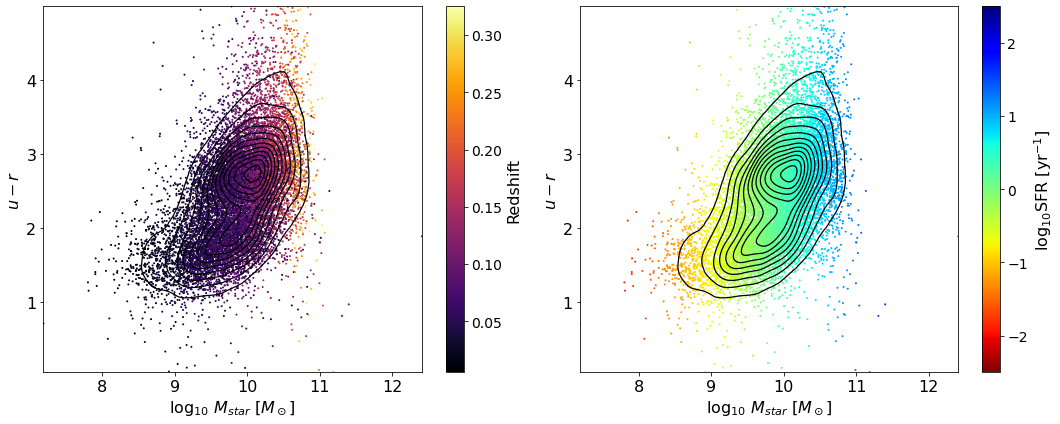

In [221]:
color_mass_splus(df_cuts, True)

In [222]:
compute_scores(df_cuts)

Mstar PCC:  0.938150024626298
Mstar MSE:  0.4961145647949471
SFR PCC:  0.0026752208857357025
SFR MSE:  1.44237748476604
